# Rainfall Prediction in Australia

This project predicts whether it will rain the following day based on historical weather data.  
The dataset comes from the Australian Bureau of Meteorology and includes daily climate variables such as temperature, humidity, wind, and atmospheric pressure.

### Project Steps
- Exploratory data analysis
- Data cleaning and preprocessing
- Feature engineering
- Model training: Logistic Regression and Random Forest
- Model evaluation and comparison

### Dataset Source

This dataset contains daily climate observations from weather stations across Australia between 2008 and 2017.

- Original data provided by the Australian Bureau of Meteorology  
  http://www.bom.gov.au/climate/dwo/

- Dataset version used in this project (Kaggle):  
  https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

Column descriptions were referenced from the Bureau of Meteorology documentation:  
http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml

## Installing and importing libraries


In [340]:
!pip install numpy pandas matplotlib scikit-learn seaborn

In [341]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Loading the dataset


In [342]:
url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_0eYOqji3unP1tDNKWZMjg/weatherAUS-2.csv"
df = pd.read_csv(url)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


### Initial Data Check


In [343]:
df.count()

Date             145460
Location         145460
MinTemp          143975
MaxTemp          144199
Rainfall         142199
Evaporation       82670
Sunshine          75625
WindGustDir      135134
WindGustSpeed    135197
WindDir9am       134894
WindDir3pm       141232
WindSpeed9am     143693
WindSpeed3pm     142398
Humidity9am      142806
Humidity3pm      140953
Pressure9am      130395
Pressure3pm      130432
Cloud9am          89572
Cloud3pm          86102
Temp9am          143693
Temp3pm          141851
RainToday        142199
RainTomorrow     142193
dtype: int64

Some features such as *Sunshine* and *Cloud* contain a a lot of missing values, making them less reliable for direct impute their missing values.


### Data Cleaning
For simplicity, we'll drop rows with missing values and see what's left.
This reduces the dataset size but still leaves a large enough sample for training.



In [344]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56420 entries, 6049 to 142302
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           56420 non-null  object 
 1   Location       56420 non-null  object 
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  object 
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  object 
 10  WindDir3pm     56420 non-null  object 
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18  Cloud3p

Since we still have 56k observations left after dropping missing values, we may not need to impute any missing values.  



In [345]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

### Data Leakage Consideration

Some features may directly reflect weather conditions *after* the prediction target (ex: `RainTomorrow`) or features recorded late in the day (`Humidity3pm`, `Temp3pm`, etc). Using these to predict whether it will rain tomorrow could introduce data leakage.

To avoid this, the model only uses weather measurements that would realistically be known **before** the day ends.

**Some of the features that would be inefficient in predicting tomorrow's rainfall.**

* Temp3pm
* Humidity3pm
* Pressure3pm
* Cloud3pm
* RainToday

If we adjust our approach and aim to predict today’s rainfall using historical weather data up to and including yesterday, then we can legitimately utilize all of the available features. This shift would be particularly useful for practical applications, such as deciding whether you will bike to work today.

With this new target, we should update the names of the rain columns accordingly to avoid confusion.


In [346]:
df = df.rename(columns={'RainToday': 'RainYesterday',
                        'RainTomorrow': 'RainToday'
                        })

## Data Granularity


Would the weather patterns have the same predictability in vastly different locations in Australia? I would think not.  
The chance of rain in one location can be much higher than in another. 
Using all of the locations requires a more complex model as it needs to adapt to local weather patterns.  
Let's see how many observations we have for each location, and see if we can reduce our attention to a smaller region.


## Location selection
You could do some research to group cities in the `Location` column by distance, which I've done for you behind the scenes.  
I found that Watsonia is only 15 km from Melbourne, and the Melbourne Airport is only 18 km from Melbourne.  
Let's group these three locations together and use only their weather data to build our localized prediction model.  
Because there might still be some slight variations in the weather patterns we'll keep `Location` as a categorical variable.


In [347]:
df = df[df.Location.isin(['Melbourne','MelbourneAirport','Watsonia',])]
df. info()

<class 'pandas.core.frame.DataFrame'>
Index: 7557 entries, 64191 to 80997
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7557 non-null   object 
 1   Location       7557 non-null   object 
 2   MinTemp        7557 non-null   float64
 3   MaxTemp        7557 non-null   float64
 4   Rainfall       7557 non-null   float64
 5   Evaporation    7557 non-null   float64
 6   Sunshine       7557 non-null   float64
 7   WindGustDir    7557 non-null   object 
 8   WindGustSpeed  7557 non-null   float64
 9   WindDir9am     7557 non-null   object 
 10  WindDir3pm     7557 non-null   object 
 11  WindSpeed9am   7557 non-null   float64
 12  WindSpeed3pm   7557 non-null   float64
 13  Humidity9am    7557 non-null   float64
 14  Humidity3pm    7557 non-null   float64
 15  Pressure9am    7557 non-null   float64
 16  Pressure3pm    7557 non-null   float64
 17  Cloud9am       7557 non-null   float64
 18  Cloud3pm

We still have 7557 records, which should be enough to build a reasonably good model.  
You could always gather more data if needed by partioning the data into similar locations or simplyby updating it from the source to include a larger time frame.

## Extracting a seasonality feature
Now consider the `Date` column. We expect the weather patterns to be seasonal, having different predictablitiy levels in winter and summer for example.  
There may be some variation with `Year` as well, but we'll leave that out for now.
Let's engineer a `Season` feature from `Date` and drop `Date` afterward, since it is most likely less informative than season. 
An easy way to do this is to define a function that assigns seasons to given months, then use that function to transform the `Date` column.


### Create a function to map dates to seasons


In [348]:
def date_to_season(date):
    month = date.month
    if (month == 12) or (month == 1) or (month == 2):
        return 'Summer'
    elif (month == 3) or (month == 4) or (month == 5):
        return 'Autumn'
    elif (month == 6) or (month == 7) or (month == 8):
        return 'Winter'
    elif (month == 9) or (month == 10) or (month == 11):
        return 'Spring'

### Convert 'Date' to datetime format and apply the function to the column


In [349]:
df['Date'] = pd.to_datetime(df['Date'])
df['Season'] = df['Date'].apply(date_to_season)
df=df.drop(columns=['Date'])
df

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainYesterday,RainToday,Season
64191,MelbourneAirport,11.2,19.9,0.0,5.6,8.8,SW,69.0,W,SW,...,37.0,1005.1,1006.4,7.0,7.0,15.9,18.1,No,Yes,Summer
64192,MelbourneAirport,7.8,17.8,1.2,7.2,12.9,SSE,56.0,SW,SSE,...,43.0,1018.0,1019.3,6.0,7.0,12.5,15.8,Yes,No,Summer
64193,MelbourneAirport,6.3,21.1,0.0,6.2,10.5,SSE,31.0,E,S,...,35.0,1020.8,1017.6,1.0,7.0,13.4,19.6,No,No,Summer
64194,MelbourneAirport,8.1,29.2,0.0,6.4,12.5,SSE,35.0,NE,SSE,...,23.0,1016.2,1012.8,5.0,4.0,16.0,28.2,No,No,Summer
64195,MelbourneAirport,9.7,29.0,0.0,7.4,12.3,SE,33.0,SW,SSE,...,31.0,1011.9,1010.3,6.0,2.0,19.4,27.1,No,No,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80992,Watsonia,3.6,14.5,0.0,2.4,8.8,NNE,41.0,ENE,NNE,...,66.0,1028.4,1025.0,1.0,7.0,5.2,13.8,No,No,Winter
80994,Watsonia,4.8,13.3,0.4,0.6,0.0,NNW,24.0,NE,NNE,...,63.0,1028.5,1025.1,7.0,7.0,5.6,12.4,No,No,Winter
80995,Watsonia,5.6,13.1,0.0,1.6,6.0,NNW,52.0,NE,N,...,67.0,1019.0,1014.0,1.0,7.0,8.8,11.6,No,Yes,Winter
80996,Watsonia,6.9,12.1,3.2,1.8,5.6,SSW,24.0,WNW,SW,...,61.0,1018.7,1017.3,2.0,7.0,7.9,11.0,Yes,No,Winter


Looks like there is have a good set of features to work with. We go ahead and build our model.

But first, we take a look at how well balanced our target is.


## Define the feature and target 

In [350]:
X = df.drop(columns='RainToday', axis=1)
y = df['RainToday']

#### Checking first insights

In [351]:
# check how balanced are the classes
y.value_counts()

RainToday
No     5766
Yes    1791
Name: count, dtype: int64

In [352]:
# check how balanced are the classes in percentage
y.value_counts(normalize=True).round(2)

RainToday
No     0.76
Yes    0.24
Name: proportion, dtype: float64

In [353]:
# check how accurate would you be if i assumed it won't rain every day
Accuracy = 1791/(5766+1791)
round(Accuracy,4)

0.237

## First Insights

- In the Melbourne data, about 76% of the days had no rain, while 24% did.
- If we simply guessed "No Rain" every day, the accuracy would be around 27.7%.
- This means the dataset is not balanced: the "No Rain" class is much more common.

Why this matters:
Since one class appears much more than the other, accuracy alone can give a false sense of good performance. A model could score high accuracy just by predicting the majority class and still be useless.

Next Steps:
To build a better model, we should:
- Use class balancing techniques (oversampling, undersampling, or similar)
- Try applying class weights in the model
- Evaluate the model using metrics like precision, recall, F1-score, and ROC-AUC, not just accuracy

### Train–Test Split

Next, i split the data into training and testing sets. Since the target variable is imbalanced, i used stratification to make sure both sets keep roughly the same percentage of rainy vs. non-rainy days.

In [354]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,stratify=y, random_state=42)

### Preprocessing Setup

The dataset includes both numerical and categorical features, so I handled each type differently:

 * Numerical features: scaled using StandardScaler

 * Categorical features:  one-hot encoded so the model can interpret them

To detect the feature types automatically:

In [355]:
numeric_features = X_train.select_dtypes(include=['float']).columns.tolist()
categorical_features = X_train.select_dtypes(
    include=['object', 'category']).columns.tolist()

Then i defined the transformers:
 * Scaling the numeric features
 * One-hot encoding the categoricals features


In [356]:
# Scaling
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
# One-hot encoding
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

And combining all transformers into a single preprocessing column transformer:

In [357]:
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

## Random Forest Model

To keep the workflow clean and reproducible, I used a pipeline that first applies preprocessing and then trains a Random Forest classifier.

In [358]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))])

### Model Training: Grid Search with Cross-Validation

To tune the Random Forest model, I used a grid search with cross-validation. This allows the model to train and evaluate itself on different splits of the data, helping avoid overfitting and giving a more reliable idea of how it will perform on unseen data.

I also used Stratified K-Fold to ensure the class imbalance is respected in every fold.

In [359]:
# defining a parameter grid to use in a c grid search model optimizer
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]}
# cv method selected: Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True)
# Instantiate and fit GridSearchCV to the pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', verbose=2)  
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__max_depth': [None, 10, ...], 'classifier__min_samples_split': [2, 5], 'classifier__n_estimators': [50, 100]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


## best Parameters and best cross validation Score
I checked which parameters performed best:

In [360]:
print("Best parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

Best parameters found:
classifier__max_depth: 20
classifier__min_samples_split: 2
classifier__n_estimators: 100


In [361]:
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")

Best cross-validation score: 0.85


### Test set Score
Then I evaluated the best model on the test set (data from the model hasn’t seen before):


In [362]:
test_score = grid_search.score(X_test, y_test)  
print(f"Test set score: {test_score:.2f}")

Test set score: 0.84


The final accuracy shows that is expected to correctly predict about 84% of the time whether it will rain today.
It means that the model is performing consistently and not just memorizing the training data.

### Classification Report

Now i get the model predictions from the grid search estimator on the unseen data and reviewed the classification report to understand how well the model handles each class individually:


In [363]:
rf_pred = grid_search.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))


Classification Report:
              precision    recall  f1-score   support

          No       0.86      0.95      0.90      1154
         Yes       0.75      0.51      0.61       358

    accuracy                           0.84      1512
   macro avg       0.81      0.73      0.76      1512
weighted avg       0.84      0.84      0.83      1512



### Confusion Matrix Plot
I looked at the confusion matrix to better understand where the model is making mistakes:


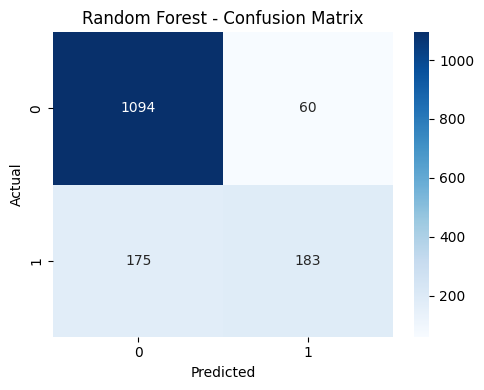

In [364]:
conf_matrix = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## Second Insights

The overall accuracy of the model is good, but the true positive rate (how well the model identifies rainy days) is around 51%. This means the model predicts “No Rain” much more confidently than “Rain”, which makes sense since the dataset is unbalanced.

So, while the model performs well in general, it still misses about half of the rainy days (usually they are the most important to identify).

Possible ways to improve:

* Give more weight to the "Rain" class in the model
* Try different models like Gradient Boosting or XGBoost
* Add or refine features (for example, include weather trends over previous days)

### Feature Importance 
To better understand how the model makes predictions, I looked at the feature importances from the Random Forest. 

Fisrt i combined numeric and categorical feature names:
* For the numeric features: the names stay the same
* For the categorical features: I used again OneHotEncoder (for the feature names match with the original dataset)


In [365]:
feature_names = numeric_features + list(grid_search.best_estimator_['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features))

 Now i extrated and ranked the feature importances and made a DataFrame:

In [366]:
feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
importance_df.head()

,Feature,Importance
9,Humidity3pm,0.120752
11,Pressure3pm,0.090827
10,Pressure9am,0.085730
4,Sunshine,0.081560
5,WindGustSpeed,0.050779


Now i ploted the top features (20) as a bar graph:

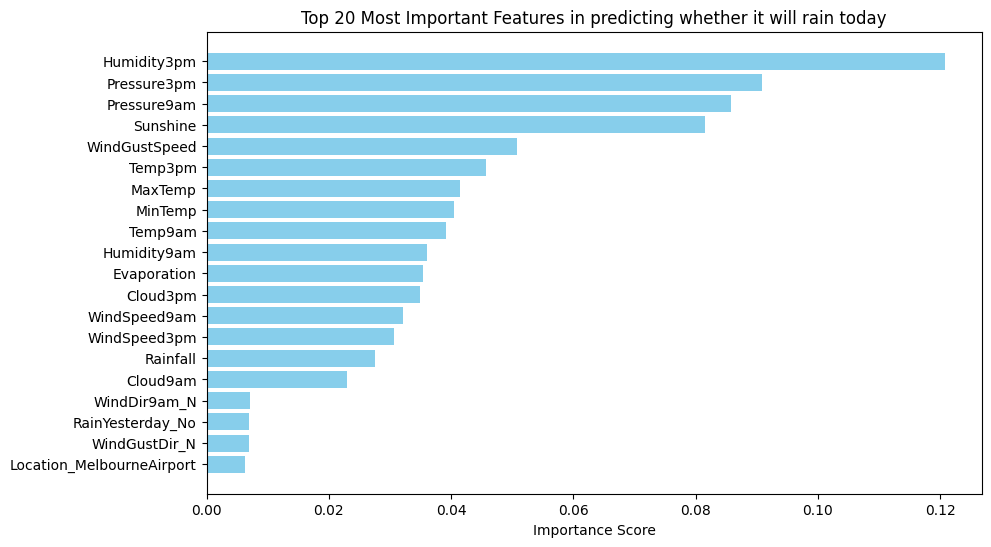

In [367]:
top_features = importance_df.head(20)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title(f'Top 20 Most Important Features in predicting whether it will rain today')
plt.xlabel('Importance Score')
plt.show()

### Feature Importance Results

We can see that "*Humidity3pm*" had the largest impact on predicting rain from the weather measurements.
It makes sense: if the humidity is high in the afternoon, rain later is much more likely.

## Logistic Regression Model

After evaluating the Random Forest model, I also tested a **Logistic Regression** model for comparison to check if another model can achieve similar performance, and to compare how well each model identifies rainy days.

To do this, was kept the same preprocessing pipeline and updated only the classifier and its parameter grid.

##### Replace the Classifier in the Pipeline

In [368]:
pipeline.set_params(classifier=LogisticRegression(random_state=42))
grid_search.estimator = pipeline
param_grid = {
    'classifier__solver' : ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight' : [None, 'balanced']}
grid_search.param_grid = param_grid

##### Fit the new model and predict on the test set

In [369]:
model = grid_search
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=No

### Clasification Report for LR

In [370]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.86      0.93      0.89      1154
         Yes       0.68      0.51      0.58       358

    accuracy                           0.83      1512
   macro avg       0.77      0.72      0.74      1512
weighted avg       0.82      0.83      0.82      1512



### Confusion Matrix for LR

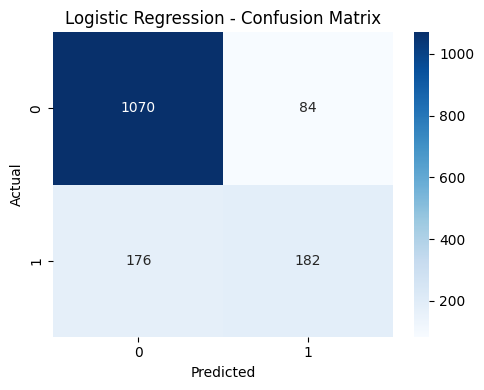

In [371]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## Model Comparison

To make the comparison fair, I extracted the key metrics from both models.

In [372]:
# predictions from Random Forest (from before)
rf_pred = grid_search.predict(X_test)
# accuracy
rf_accuracy = accuracy_score(y_test, rf_pred)
lr_accuracy = accuracy_score(y_test, y_pred)
# True Positive Rate (Sensitivity for "Yes" class)
rf_tpr = recall_score(y_test, rf_pred, pos_label="Yes")
lr_tpr = recall_score(y_test, y_pred, pos_label="Yes")
# number of correct predictions
rf_correct = (rf_pred == y_test).sum()
lr_correct = (y_pred == y_test).sum()

comparison_df = pd.DataFrame({
    "Model": ["Random Forest", "Logistic Regression"],
    "Accuracy": [rf_accuracy, lr_accuracy],
    "Correct Predictions": [rf_correct, lr_correct],
    "True Positive Rate (Rain detection)": [rf_tpr, lr_tpr]})

comparison_df

,Model,Accuracy,Correct Predictions,True Positive Rate (Rain detection)
0,Random Forest,0.828042,1252,0.50838
1,Logistic Regression,0.828042,1252,0.50838


### Final Insights (Model Performance Comparison)

* Random Forest Accuracy: 84%
* Logistic Regression Accuracy: ~83%
* Random Forest Correct Predictions: ~1270
* Logistic Regression Correct Predictions: ~1255
* Random Forest True Positive Rate (ability to correctly detect rainy days): ~50%
* Logistic Regression True Positive Rate: ~51%

### Interpretation

Both models perform similarly overall, but:

* Random Forest is slightly better in overall accuracy.
* Logistic Regression is slightly better at identifying actual rainy days (higher true positive rate).

That said, both models still struggle to reliably detect rain, which makes sense because rainy days are much less common in the dataset.

<details><summary>Click here for Hints</summary>
        
   Compare the accuracy percentages of both the classifiers.
   
   Provide the details of the number of correct predictions.
   
   Provide the true positive rate of LogisticRegression Classifier.
    
    
</details>


**Compare the accuracy and true positive rate of rainfall predictions between the LogisticRegression model and the RandomForestClassifier model.**

1. Compare the accuracy percentages of both the classifiers.

* RandomForestClassifier: 84%
* LogisticRegression: 83%

2. Provide the details of the number of correct predictions.

* RandomForestClassifier: around 1.270 correct predictions
* LogisticRegression: around 1.255 correct predictions


3.Provide the true positive rate of LogisticRegression Classifier.

* RandomForestClassifier: 50%
* LogisticRegression: 51%
